<a href="https://colab.research.google.com/github/Dragorrik/ML-BeanDiseaseAnalysis/blob/main/BeanDisease_ThesisAnalysis_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install kaggle

In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download therealoise/bean-disease-dataset

 98% 128M/131M [00:05<00:00, 36.9MB/s]
100% 131M/131M [00:05<00:00, 23.9MB/s]


In [ ]:
!unzip bean-disease-dataset.zip

Archive:  bean-disease-dataset.zip
  inflating: Bean_Dataset/angular_leaf_spot/angular_leaf_spot_01.jpg  
  inflating: Bean_Dataset/angular_leaf_spot/angular_leaf_spot_02.jpg  
  inflating: Bean_Dataset/angular_leaf_spot/angular_leaf_spot_03.jpg  
  inflating: Bean_Dataset/angular_leaf_spot/angular_leaf_spot_04.jpg  
  inflating: Bean_Dataset/angular_leaf_spot/angular_leaf_spot_05.jpg  
  inflating: Bean_Dataset/angular_leaf_spot/angular_leaf_spot_06.jpg  
  inflating: Bean_Dataset/angular_leaf_spot/angular_leaf_spot_07.jpg  
  inflating: Bean_Dataset/angular_leaf_spot/angular_leaf_spot_08.jpg  
  inflating: Bean_Dataset/angular_leaf_spot/angular_leaf_spot_09.jpg  
  inflating: Bean_Dataset/angular_leaf_spot/angular_leaf_spot_10.jpg  
  inflating: Bean_Dataset/angular_leaf_spot/angular_leaf_spot_100.jpg  
  inflating: Bean_Dataset/angular_leaf_spot/angular_leaf_spot_101.jpg  
  inflating: Bean_Dataset/angular_leaf_spot/angular_leaf_spot_102.jpg  
  inflating: Bean_Dataset/angular_leaf_

In [ ]:
!ls

Bean_Dataset  bean-disease-dataset.zip	kaggle.json  sample_data


In [ ]:
%matplotlib inline

#ignoring warnings
import warnings
warnings.filterwarnings('ignore')

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.models import load_model

import os

In [ ]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/Bean_Dataset",
    seed=85,
    # To randomly shuffle all the images
    shuffle=True,
    # Input image size
    image_size=(256, 256),
    # Set batch size to 32
    batch_size=32
)

Found 990 files belonging to 3 classes.


In [ ]:
bean_classes = dataset.class_names
bean_classes

['angular_leaf_spot', 'bean_rust', 'healthy']

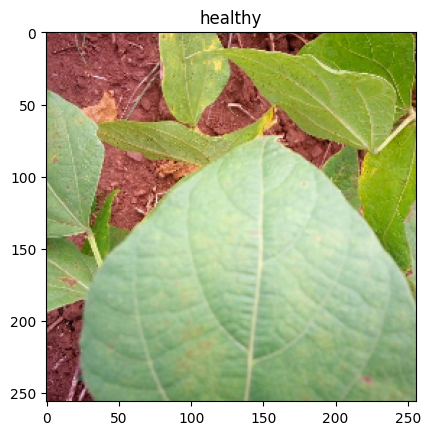

In [ ]:
# Printing an image
for image_batch, labels_batch in dataset.take(1):
    plt.imshow(image_batch[1].numpy().astype("uint8"))
    plt.title(bean_classes[labels_batch[0]])

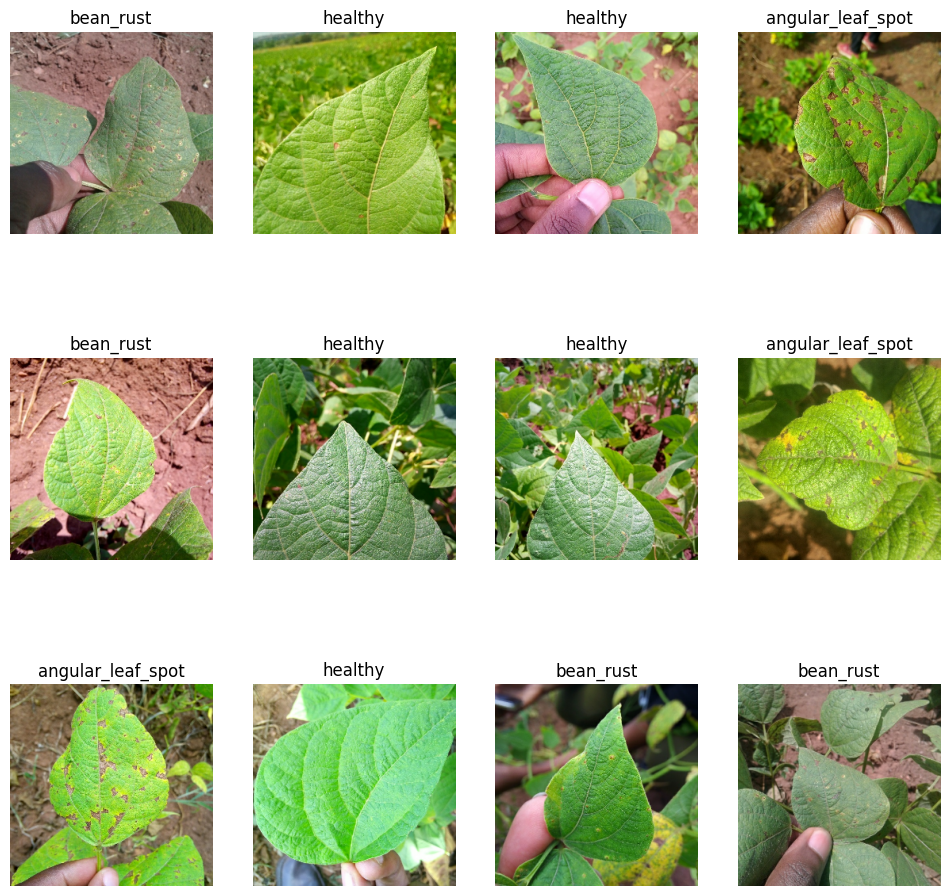

In [ ]:
# First 12 images in the a batch
plt.figure(figsize=(12, 12))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(bean_classes[labels_batch[i]])
        plt.axis("off")

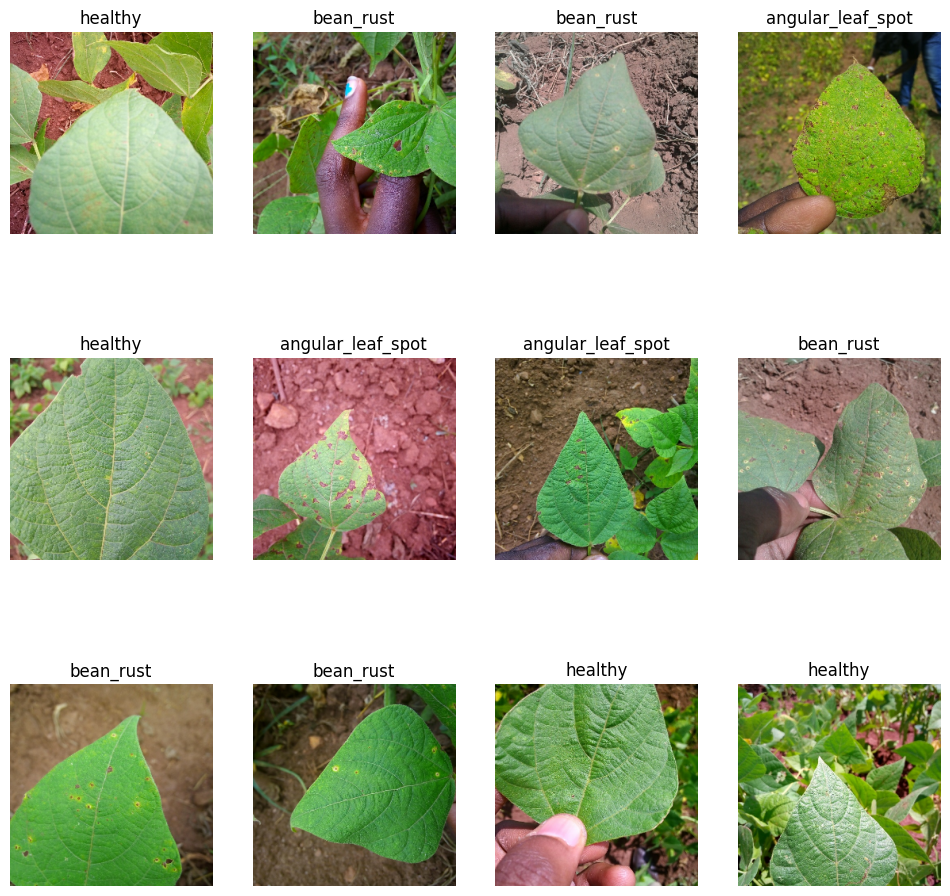

In [ ]:
plt.figure(figsize=(12, 12))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(bean_classes[labels_batch[i]])
        plt.axis("off")

In [ ]:
# Print the number of batches
# In our dataset
len(dataset)

31

In [ ]:
def get_dataset_partitions_tf(dataset, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    """
    Takes a dataset and splits it into train, validation and test sets.
    """
    dataset_size = len(dataset)

    if shuffle:
        dataset = dataset.shuffle(shuffle_size, seed=85)

    train_size = int(train_split * dataset_size)
    val_size = int(val_split * dataset_size)

    train_set = dataset.take(train_size)
    val_set = dataset.skip(train_size).take(val_size)
    test_set = dataset.skip(train_size).skip(val_size)

    return train_set, val_set, test_set

In [ ]:
train_set, val_set, test_set = get_dataset_partitions_tf(dataset)

In [ ]:
# Visualize the lenght of our splits
len(train_set), len(val_set), len(test_set)

(24, 3, 4)

In [ ]:
print("Configuring the dataset for better performance")
train_set = train_set.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_set = val_set.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_set = test_set.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

Configuring the dataset for better performance


In [ ]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(256, 256),
  layers.experimental.preprocessing.Rescaling(1.0/255),
])

In [ ]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [ ]:
# Apply data augmentation to train dataset

train_set = train_set.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
input_shape = (32, 256, 256, 3)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(16,(3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(32,(3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(16,(3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(16,(3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [ ]:
# View summary of our model parameters
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 32)          0         
 g2D)                                                 

In [ ]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
history = model.fit(
    train_set,
    batch_size=32,
    validation_data=val_set,
    verbose=1,
    epochs=1,
)

24/24 [==============================] - 64s 2s/step - loss: 1.0948 - accuracy: 0.3303 - val_loss: 1.0836 - val_accuracy: 0.3333


In [ ]:
# Evaluate model performance on test set
scores = model.evaluate(test_set)

4/4 [==============================] - 4s 425ms/step - loss: 1.0678 - accuracy: 0.3828


In [ ]:
scores

[1.0677623748779297, 0.3828125]

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

In [ ]:
%matplotlib inline

# ignoring warnings
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

import os

# Load the ResNet50 model with pre-trained weights (excluding the top layers)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Freeze the pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom top layers for your specific task
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(64, activation='relu')(x)
predictions = Dense(len(bean_classes), activation='softmax')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

# View the summary of the model
model.summary()


94765736/94765736 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 262, 262, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 128, 128, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 128, 128, 64)         256       ['conv1_conv[0][0]']          
 on)                         

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Define a ModelCheckpoint callback
checkpoint_filepath = 'model_checkpoint.h5'
model_checkpoint = ModelCheckpoint(filepath=checkpoint_filepath, save_best_only=True, save_weights_only=False)

In [ ]:

# Train the model
history = model.fit(
    train_set,
    batch_size=32,
    validation_data=val_set,
    verbose=1,
    epochs=1,
)

# Evaluate the model on the test set
scores = model.evaluate(test_set)
print("Test set - Loss: {:.4f}, Accuracy: {:.4f}".format(scores[0], scores[1]))


4/4 [==============================] - 30s 8s/step - loss: 0.3953 - accuracy: 0.8438
Test set - Loss: 0.3953, Accuracy: 0.8438


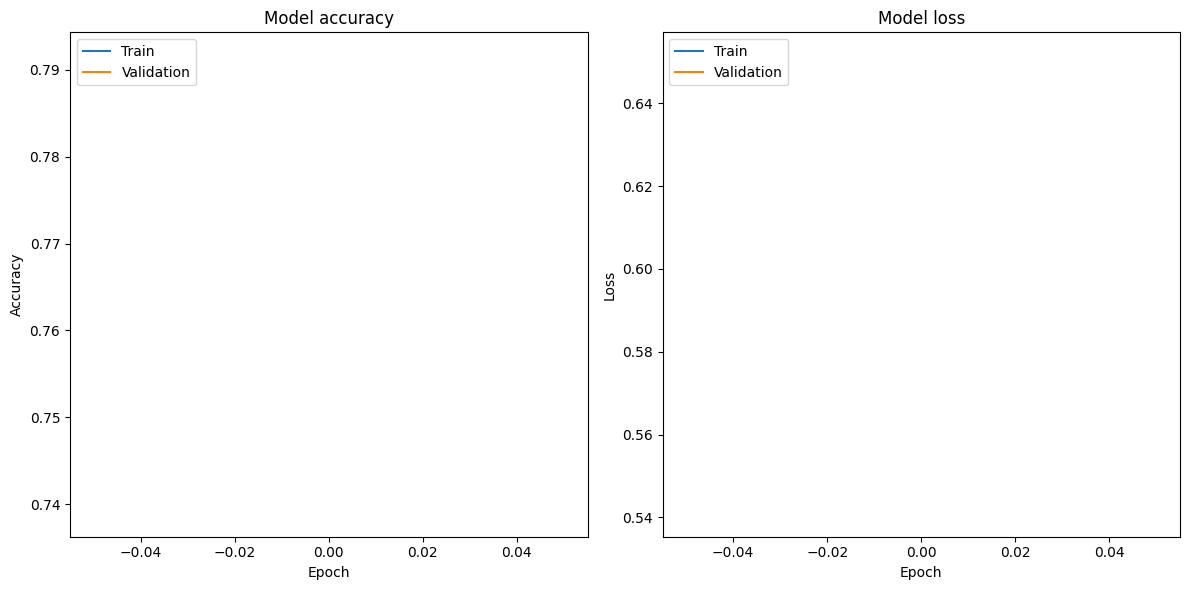

In [ ]:

# Plotting the loss and accuracy curves
plt.figure(figsize=(12, 6))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

# Show the plots
plt.tight_layout()
plt.show()

Found 990 files belonging to 3 classes.
Using 792 files for training.
Found 990 files belonging to 3 classes.
Using 198 files for validation.
Class names: ['angular_leaf_spot', 'bean_rust', 'healthy']
87910968/87910968 [==============================] - 0s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d_6 (Conv2D)           (None, 127, 127, 32)         864       ['input_2[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 127, 127, 32)         96        ['conv2d_6[0][0]']            
 Normalization)         

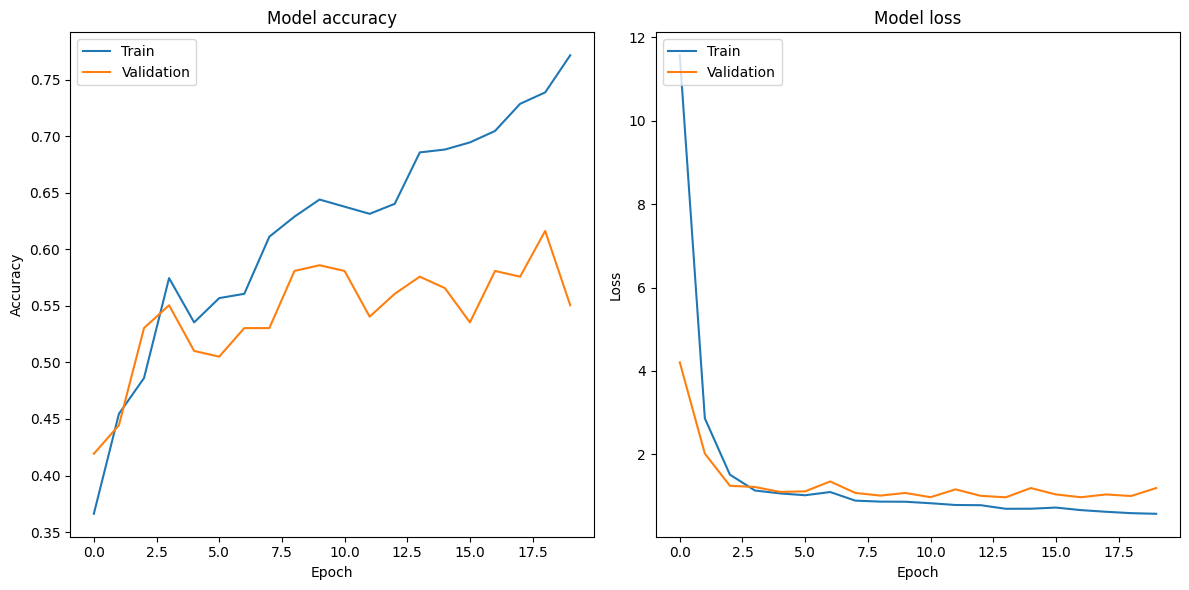

In [ ]:
#InceptionV3 Model
%matplotlib inline

# ignoring warnings
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import classification_report

# Specify the path to your dataset
dataset_path = "/content/Bean_Dataset"

# Load the dataset using image_dataset_from_directory
batch_size = 32
img_height, img_width = 256, 256

train_set = image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
)

val_set = image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
)

# Print the class names
class_names = train_set.class_names
print("Class names:", class_names)

# Define the InceptionV3 model
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Freeze the pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom top layers for your specific task
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(64, activation='relu')(x)
predictions = Dense(len(class_names), activation='softmax')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

# View the summary of the model
model.summary()

# Define a ModelCheckpoint callback
checkpoint_filepath = 'inception_model_checkpoint.h5'
model_checkpoint = ModelCheckpoint(filepath=checkpoint_filepath, save_best_only=True, save_weights_only=False)

# Train the model with the ModelCheckpoint callback
history = model.fit(
    train_set,
    validation_data=val_set,
    epochs=20,  # Adjust the number of epochs as needed
    callbacks=[model_checkpoint]
)

# Evaluate the model on the validation set
scores = model.evaluate(val_set)
print("Validation set - Loss: {:.4f}, Accuracy: {:.4f}".format(scores[0], scores[1]))

# Evaluate precision, recall, and F1 Score
# Get the true labels and predicted labels
y_true = []
y_pred = []

for images, labels in val_set:
    y_true.extend(labels.numpy())
    predictions = model.predict(images).argmax(axis=1)
    y_pred.extend(predictions)

# Print the classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

# Plotting the loss and accuracy curves
plt.figure(figsize=(12, 6))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

# Show the plots
plt.tight_layout()
plt.show()


Found 990 files belonging to 3 classes.
Using 792 files for training.
Found 990 files belonging to 3 classes.
Using 198 files for validation.
Class names: ['angular_leaf_spot', 'bean_rust', 'healthy']
58889256/58889256 [==============================] - 0s 0us/step
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73

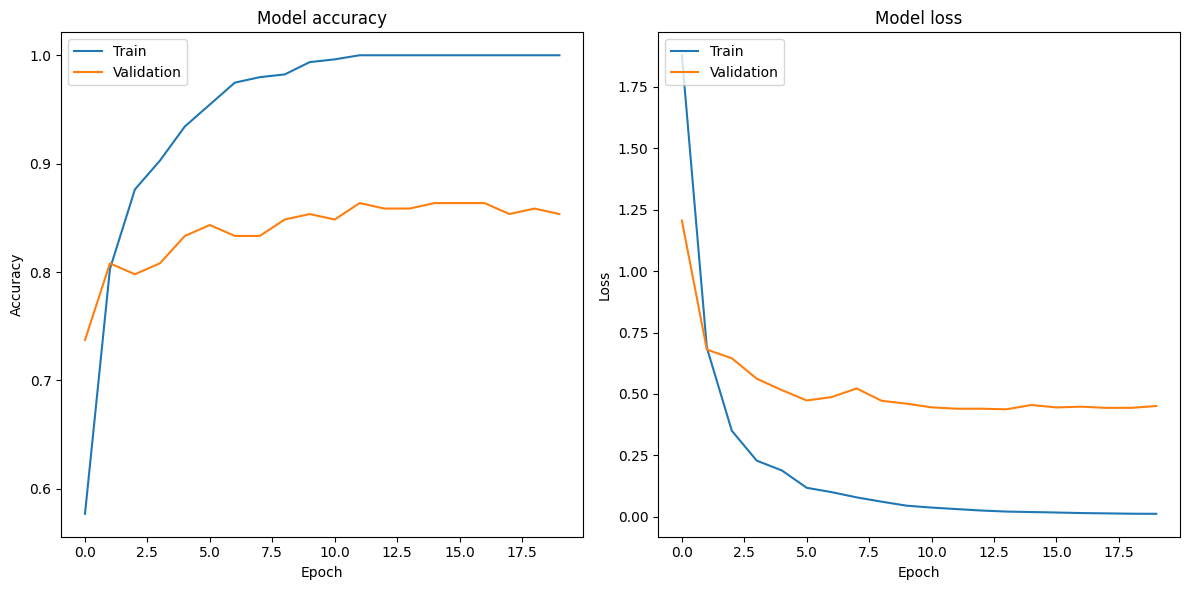

In [ ]:
#VGG16 Model
%matplotlib inline

# ignoring warnings
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import classification_report

# Specify the path to your dataset
dataset_path = "/content/Bean_Dataset"

# Load the dataset using image_dataset_from_directory
batch_size = 32
img_height, img_width = 256, 256

train_set = image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
)

val_set = image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
)

# Print the class names
class_names = train_set.class_names
print("Class names:", class_names)

# Define the VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Freeze the pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom top layers for your specific task
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(64, activation='relu')(x)
predictions = Dense(len(class_names), activation='softmax')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

# View the summary of the model
model.summary()

# Define a ModelCheckpoint callback
checkpoint_filepath = 'vgg16_model_checkpoint.h5'
model_checkpoint = ModelCheckpoint(filepath=checkpoint_filepath, save_best_only=True, save_weights_only=False)

# Train the model with the ModelCheckpoint callback
history = model.fit(
    train_set,
    validation_data=val_set,
    epochs=20,  # Adjust the number of epochs as needed
    callbacks=[model_checkpoint]
)

# Evaluate the model on the validation set
scores = model.evaluate(val_set)
print("Validation set - Loss: {:.4f}, Accuracy: {:.4f}".format(scores[0], scores[1]))

# Evaluate precision, recall, and F1 Score
# Get the true labels and predicted labels
y_true = []
y_pred = []

for images, labels in val_set:
    y_true.extend(labels.numpy())
    predictions = model.predict(images).argmax(axis=1)
    y_pred.extend(predictions)

# Print the classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

# Plotting the loss and accuracy curves
plt.figure(figsize=(12, 6))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

# Show the plots
plt.tight_layout()
plt.show()


Found 990 files belonging to 3 classes.
Using 792 files for training.
Found 990 files belonging to 3 classes.
Using 198 files for validation.
Class names: ['angular_leaf_spot', 'bean_rust', 'healthy']
83683744/83683744 [==============================] - 0s 0us/step
Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 127, 127, 32)         864       ['input_4[0][0]']             
                                                                                                  
 block1_conv1_bn (BatchNorm  (None, 127, 127, 32)         128       ['block1_conv1[0][0]']        
 alization)             

1/1 [==============================] - 2s 2s/step

Classification Report:
                   precision    recall  f1-score   support

angular_leaf_spot       0.66      0.78      0.71        67
        bean_rust       0.70      0.48      0.57        73
          healthy       0.62      0.74      0.68        58

         accuracy                           0.66       198
        macro avg       0.66      0.67      0.65       198
     weighted avg       0.66      0.66      0.65       198



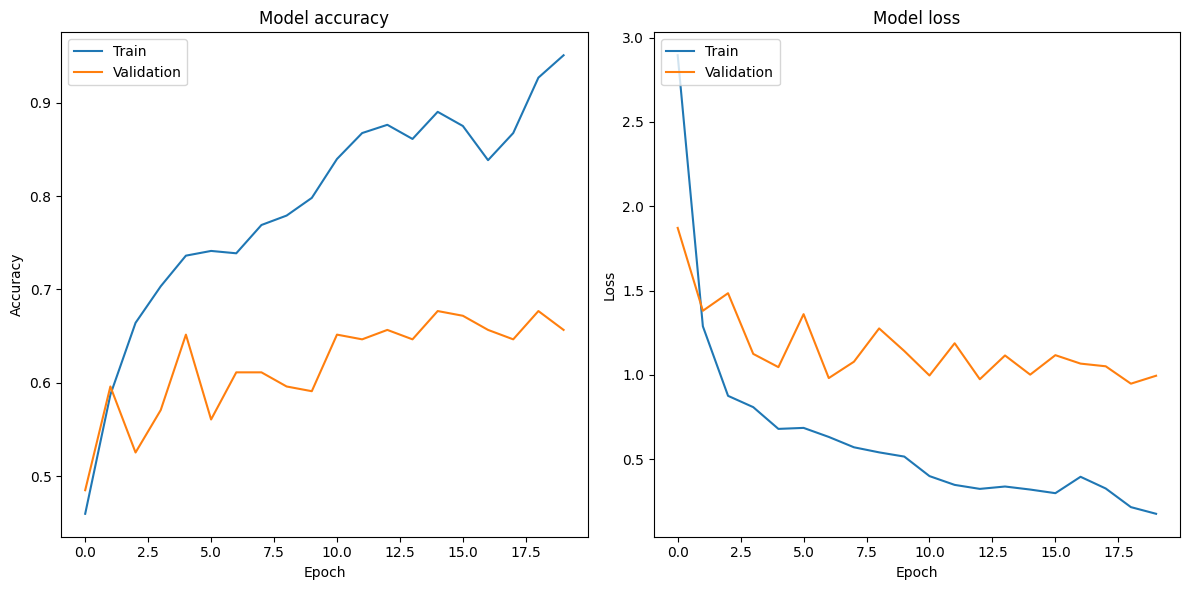

In [ ]:
#Xception Model
%matplotlib inline

# ignoring warnings
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import Xception
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import classification_report

# Specify the path to your dataset
dataset_path = "/content/Bean_Dataset"

# Load the dataset using image_dataset_from_directory
batch_size = 32
img_height, img_width = 256, 256

train_set = image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
)

val_set = image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
)

# Print the class names
class_names = train_set.class_names
print("Class names:", class_names)

# Define the Xception model
base_model = Xception(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Freeze the pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom top layers for your specific task
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(64, activation='relu')(x)
predictions = Dense(len(class_names), activation='softmax')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

# View the summary of the model
model.summary()

# Define a ModelCheckpoint callback
checkpoint_filepath = 'xception_model_checkpoint.h5'
model_checkpoint = ModelCheckpoint(filepath=checkpoint_filepath, save_best_only=True, save_weights_only=False)

# Train the model with the ModelCheckpoint callback
history = model.fit(
    train_set,
    validation_data=val_set,
    epochs=20,  # Adjust the number of epochs as needed
    callbacks=[model_checkpoint]
)

# Evaluate the model on the validation set
scores = model.evaluate(val_set)
print("Validation set - Loss: {:.4f}, Accuracy: {:.4f}".format(scores[0], scores[1]))

# Evaluate precision, recall, and F1 Score
# Get the true labels and predicted labels
y_true = []
y_pred = []

for images, labels in val_set:
    y_true.extend(labels.numpy())
    predictions = model.predict(images).argmax(axis=1)
    y_pred.extend(predictions)

# Print the classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

# Plotting the loss and accuracy curves
plt.figure(figsize=(12, 6))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

# Show the plots
plt.tight_layout()
plt.show()



Found 990 files belonging to 3 classes.
Using 792 files for training.
Found 990 files belonging to 3 classes.
Using 198 files for validation.


Class names: ['angular_leaf_spot', 'bean_rust', 'healthy']
17225924/17225924 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 128, 128, 32)      864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 128, 128, 32)      128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 128, 128, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 128, 128, 32)      288       
 )                                                               
   

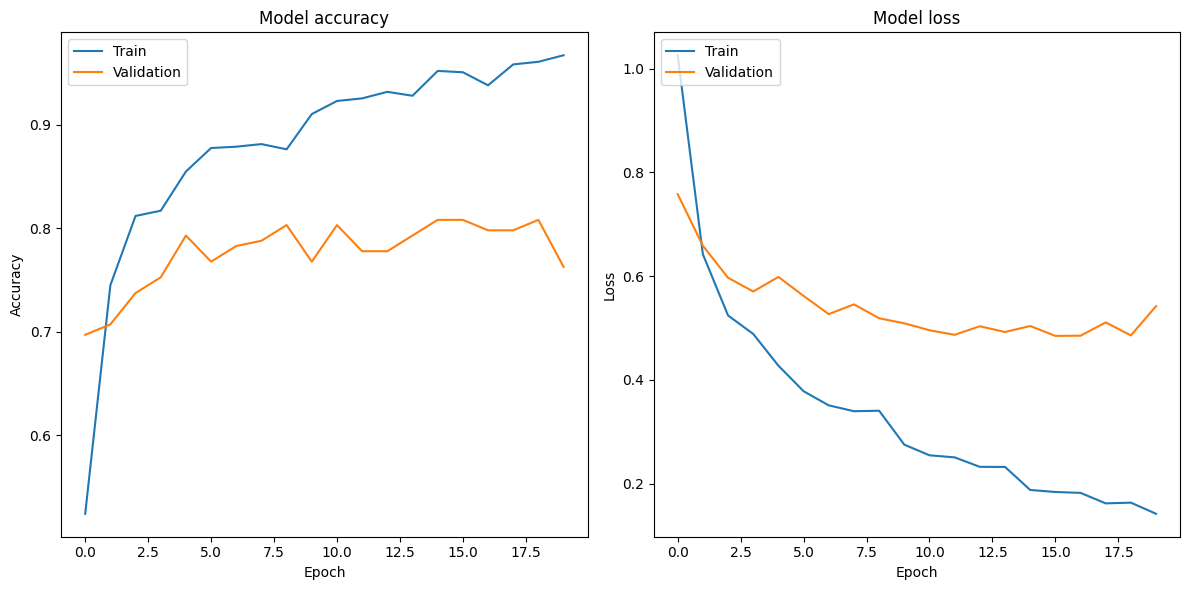

In [ ]:
# MobileNet Model
%matplotlib inline

# ignoring warnings
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import classification_report

# Specify the path to your dataset
dataset_path = "/content/Bean_Dataset"

# Load the dataset using image_dataset_from_directory
batch_size = 32
img_height, img_width = 256, 256

train_set = image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
)

val_set = image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
)

# Print the class names
class_names = train_set.class_names
print("Class names:", class_names)

# Define the MobileNet model
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Freeze the pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom top layers for your specific task
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(64, activation='relu')(x)
predictions = Dense(len(class_names), activation='softmax')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

# View the summary of the model
model.summary()

# Define a ModelCheckpoint callback
checkpoint_filepath = 'mobilenet_model_checkpoint.h5'
model_checkpoint = ModelCheckpoint(filepath=checkpoint_filepath, save_best_only=True, save_weights_only=False)

# Train the model with the ModelCheckpoint callback
history = model.fit(
    train_set,
    validation_data=val_set,
    epochs=20,  # Adjust the number of epochs as needed
    callbacks=[model_checkpoint]
)

# Evaluate the model on the validation set
scores = model.evaluate(val_set)
print("Validation set - Loss: {:.4f}, Accuracy: {:.4f}".format(scores[0], scores[1]))

# Evaluate precision, recall, and F1 Score
# Get the true labels and predicted labels
y_true = []
y_pred = []

for images, labels in val_set:
    y_true.extend(labels.numpy())
    predictions = model.predict(images).argmax(axis=1)
    y_pred.extend(predictions)

# Print the classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

# Plotting the loss and accuracy curves
plt.figure(figsize=(12, 6))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

# Show the plots
plt.tight_layout()
plt.show()


Found 990 files belonging to 3 classes.
Using 792 files for training.
Found 990 files belonging to 3 classes.
Using 198 files for validation.
Class names: ['angular_leaf_spot', 'bean_rust', 'healthy']
16705208/16705208 [==============================] - 1s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 256, 256, 3)          0         ['input_2[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, 256, 256, 3)          7         ['rescaling[0][0]']           
 on)                    

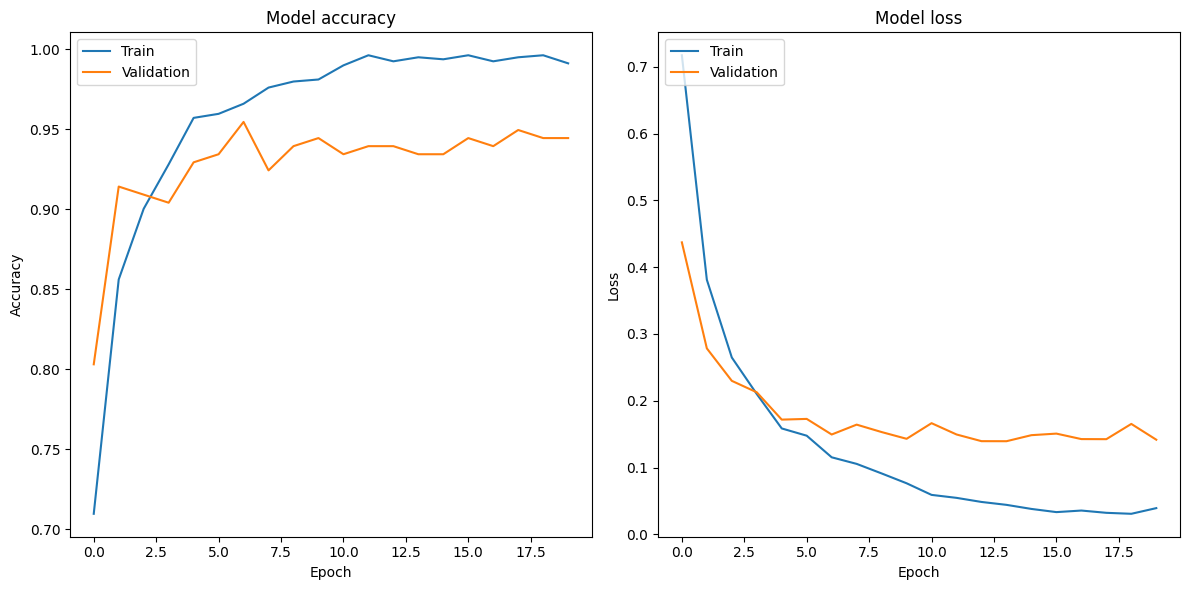

In [ ]:
# EfficientNet Model
%matplotlib inline

# ignoring warnings
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import classification_report

# Specify the path to your dataset
dataset_path = "/content/Bean_Dataset"

# Load the dataset using image_dataset_from_directory
batch_size = 32
img_height, img_width = 256, 256

train_set = image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
)

val_set = image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
)

# Print the class names
class_names = train_set.class_names
print("Class names:", class_names)

# Define the EfficientNetB0 model
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Freeze the pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom top layers for your specific task
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(64, activation='relu')(x)
predictions = Dense(len(class_names), activation='softmax')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

# View the summary of the model
model.summary()

# Define a ModelCheckpoint callback
checkpoint_filepath = 'efficientnet_model_checkpoint.h5'
model_checkpoint = ModelCheckpoint(filepath=checkpoint_filepath, save_best_only=True, save_weights_only=False)

# Train the model with the ModelCheckpoint callback
history = model.fit(
    train_set,
    validation_data=val_set,
    epochs=20,  # Adjust the number of epochs as needed
    callbacks=[model_checkpoint]
)

# Evaluate the model on the validation set
scores = model.evaluate(val_set)
print("Validation set - Loss: {:.4f}, Accuracy: {:.4f}".format(scores[0], scores[1]))

# Evaluate precision, recall, and F1 Score
# Get the true labels and predicted labels
y_true = []
y_pred = []

for images, labels in val_set:
    y_true.extend(labels.numpy())
    predictions = model.predict(images).argmax(axis=1)
    y_pred.extend(predictions)

# Print the classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

# Plotting the loss and accuracy curves
plt.figure(figsize=(12, 6))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

# Show the plots
plt.tight_layout()
plt.show()


Found 990 files belonging to 3 classes.
Using 792 files for training.
Found 990 files belonging to 3 classes.
Using 198 files for validation.
Class names: ['angular_leaf_spot', 'bean_rust', 'healthy']
94765736/94765736 [==============================] - 3s 0us/step
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 262, 262, 3)          0         ['input_3[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 128, 128, 64)         9472      ['conv1_pad[0][0]']           
                        

1/1 [==============================] - 2s 2s/step

Classification Report:
                   precision    recall  f1-score   support

angular_leaf_spot       0.93      0.84      0.88        67
        bean_rust       0.84      0.95      0.89        73
          healthy       0.98      0.95      0.96        58

         accuracy                           0.91       198
        macro avg       0.92      0.91      0.91       198
     weighted avg       0.91      0.91      0.91       198



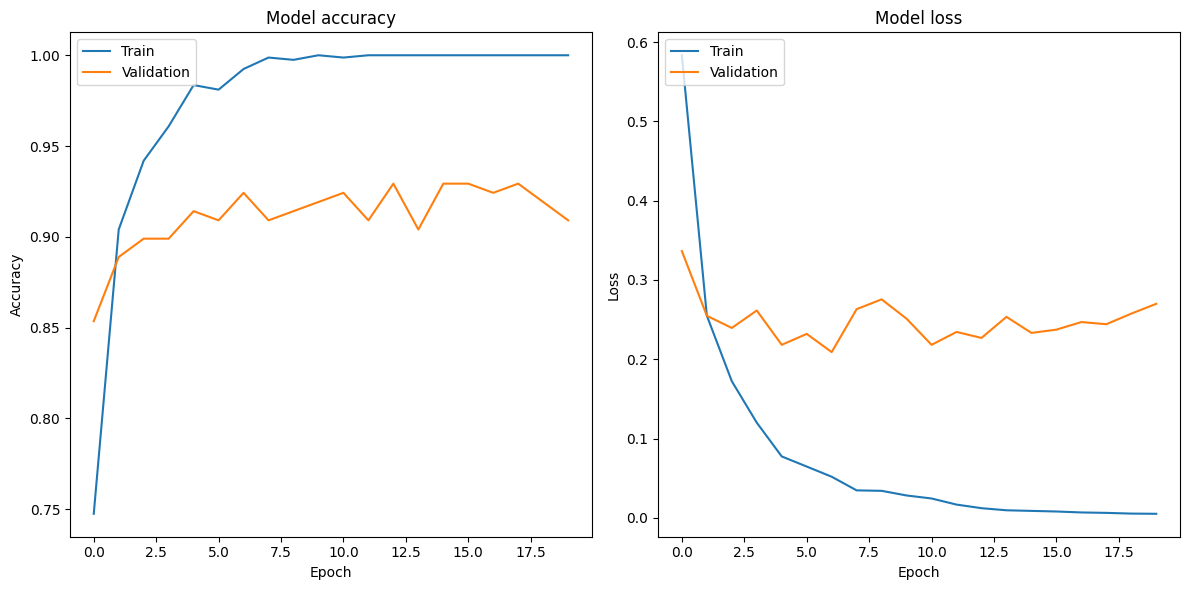

In [ ]:
#RestNet50 Model
%matplotlib inline

# ignoring warnings
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import classification_report

# Specify the path to your dataset
dataset_path = "/content/Bean_Dataset"

# Load the dataset using image_dataset_from_directory
batch_size = 32
img_height, img_width = 256, 256

train_set = image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
)

val_set = image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
)

# Print the class names
class_names = train_set.class_names
print("Class names:", class_names)

# Define the ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Freeze the pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom top layers for your specific task
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(64, activation='relu')(x)
predictions = Dense(len(class_names), activation='softmax')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

# View the summary of the model
model.summary()

# Define a ModelCheckpoint callback
checkpoint_filepath = 'resnet50_model_checkpoint.h5'
model_checkpoint = ModelCheckpoint(filepath=checkpoint_filepath, save_best_only=True, save_weights_only=False)

# Train the model with the ModelCheckpoint callback
history = model.fit(
    train_set,
    validation_data=val_set,
    epochs=20,  # Adjust the number of epochs as needed
    callbacks=[model_checkpoint]
)

# Evaluate the model on the validation set
scores = model.evaluate(val_set)
print("Validation set - Loss: {:.4f}, Accuracy: {:.4f}".format(scores[0], scores[1]))

# Evaluate precision, recall, and F1 Score
# Get the true labels and predicted labels
y_true = []
y_pred = []

for images, labels in val_set:
    y_true.extend(labels.numpy())
    predictions = model.predict(images).argmax(axis=1)
    y_pred.extend(predictions)

# Print the classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

# Plotting the loss and accuracy curves
plt.figure(figsize=(12, 6))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

# Show the plots
plt.tight_layout()
plt.show()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_104 (Conv2D)         (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 127, 127, 32)      0         
 ng2D)                                                           
                                                                 
 conv2d_105 (Conv2D)         (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 62, 62, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_106 (Conv2D)         (None, 60, 60, 128)       73856     
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 30, 30, 128)      

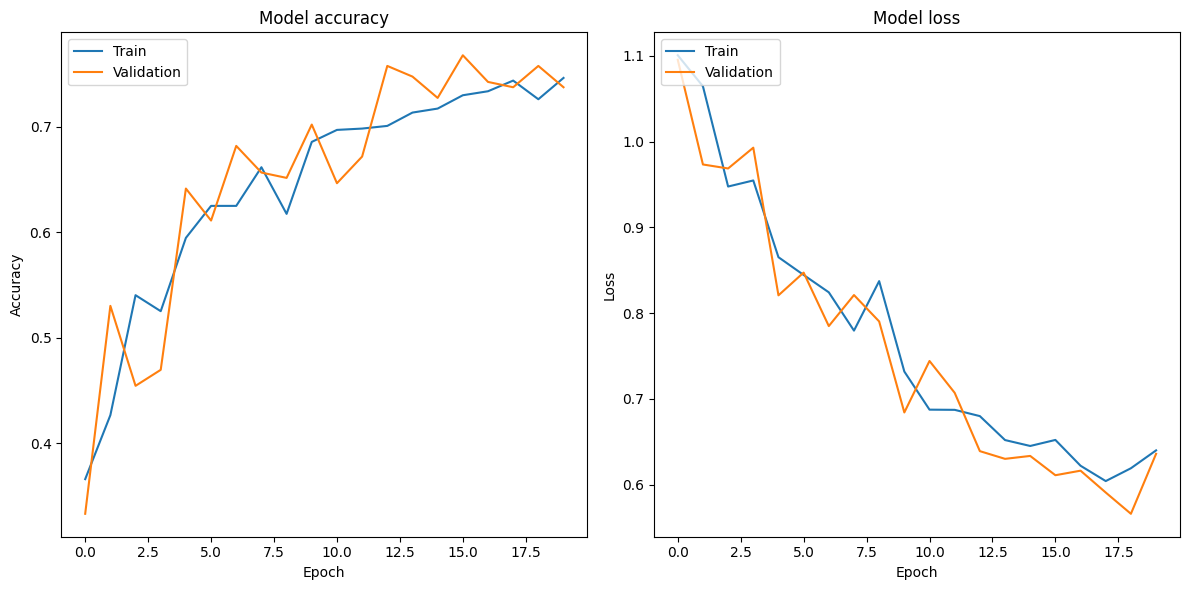

In [ ]:
# CNN with Multiple Layers
%matplotlib inline

# ignoring warnings
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint

# Define your custom CNN model with multiple convolutional layers
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.GlobalAveragePooling2D(),

    layers.Dense(128, activation='relu'),
    layers.Dense(3, activation='softmax')  # Assuming there are three classes
])

# Compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

# View the summary of the model
model.summary()

# Use ImageDataGenerator for data augmentation
datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  # Split the data into training and validation sets
)

# Load the dataset using flow_from_directory
batch_size = 32
train_set = datagen.flow_from_directory(
    '/content/Bean_Dataset',
    target_size=(256, 256),
    batch_size=batch_size,
    class_mode='sparse',
    subset='training',  # Use 'training' for the training set
    seed=85
)

val_set = datagen.flow_from_directory(
    '/content/Bean_Dataset',
    target_size=(256, 256),
    batch_size=batch_size,
    class_mode='sparse',
    subset='validation',  # Use 'validation' for the validation set
    seed=85
)

# Define a ModelCheckpoint callback
checkpoint_filepath = 'custom_cnn_model_checkpoint.h5'
model_checkpoint = ModelCheckpoint(filepath=checkpoint_filepath, save_best_only=True, save_weights_only=False)

# Train the model with the ModelCheckpoint callback
history = model.fit(
    train_set,
    validation_data=val_set,
    epochs=20,  # Increase the number of epochs for better training
    callbacks=[model_checkpoint]
)

# Evaluate the model on the test set (assuming you have a test set)
# If not, you can create a test set using a similar approach as the train and val sets
# test_datagen = ImageDataGenerator(rescale=1./255)
# test_set = test_datagen.flow_from_directory(
#     '/content/Bean_Dataset/test',
#     target_size=(256, 256),
#     batch_size=32,
#     class_mode='sparse',
#     seed=85
# )
# scores = model.evaluate(test_set)

# Plotting the loss and accuracy curves
plt.figure(figsize=(12, 6))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

# Show the plots
plt.tight_layout()
plt.show()
